In [1]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
#from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq
import model
from PIL import Image

In [2]:
normalize = transforms.Normalize(mean=mean, std=std)
img_preprocess = transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ])
mask_preprocess = transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
    ])

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=1, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False,
    num_workers=1, pin_memory=False)

mask_dir = './activation_mask/cropped_masks/'
mask_dataset = datasets.ImageFolder(
        mask_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

mask_loader = torch.utils.data.DataLoader(
    mask_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=1, pin_memory=False)

In [23]:
ppnet = torch.load(r'/scratch/users/jiaxun1218/saved_models/densenet121/r3_0.7463.pth')
ppnet = torch.nn.DataParallel(ppnet)

In [24]:
bad_img_idx = [193, 1764, 2472, 3082]
percentile_threshold = 95
total_overlap = 0
num_imgs = len(test_dataset.imgs)
for i in tqdm(range(num_imgs)):
    if i in bad_img_idx:
        continue
    test_img_dir = test_dataset.imgs[i][0]
    sub_dir = test_img_dir[44:-4]
    test_img = Image.open(test_img_dir)
        
    test_img = img_preprocess(test_img)
    mask_img_dir = mask_dir + sub_dir + '.png'
    mask_img = Image.open(mask_img_dir)
    mask_img = mask_preprocess(mask_img).numpy()
    
    ppnet.eval()
    n_prototypes = ppnet.module.num_prototypes
    num_per_class = n_prototypes // 200
    prototype_shape = ppnet.module.prototype_shape
    max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
    protoL_rf_info = ppnet.module.proto_layer_rf_info

    test_img = test_img.unsqueeze(0).cuda()
    protoL_input_torch, proto_dist_torch = ppnet.module.push_forward(test_img)
    proto_dist = proto_dist_torch.detach().cpu().numpy()
    
    img_overlap = 0

    class_identity = test_dataset.imgs[i][1]
    for j in range(num_per_class):
        act_pattern = np.log((proto_dist[0][class_identity * num_per_class + j] + 1)/(proto_dist[0][class_identity * num_per_class + j] + ppnet.module.epsilon))
        upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        th = np.percentile(upsampled_act_pattern, percentile_threshold)
        upsampled_act_pattern = (upsampled_act_pattern > th) * upsampled_act_pattern
        
        prototype_overlap = np.sum(np.multiply(mask_img, upsampled_act_pattern)) / np.sum(upsampled_act_pattern)
        img_overlap += prototype_overlap 
        
    img_overlap = img_overlap / num_per_class
    total_overlap += img_overlap 
    #print(img_overlap)
    
print("Final score: ", total_overlap / num_imgs)
    

100%|██████████| 5794/5794 [02:37<00:00, 36.78it/s]

Final score:  0.8908564062412343


In [32]:
upsampled_act_pattern.shape

(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


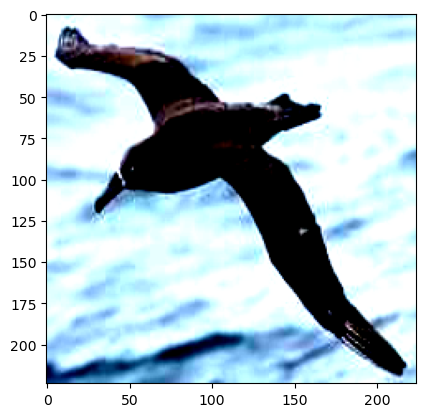

In [18]:
plt.imshow(test_img.detach().cpu().numpy()[0].transpose(1, 2, 0))

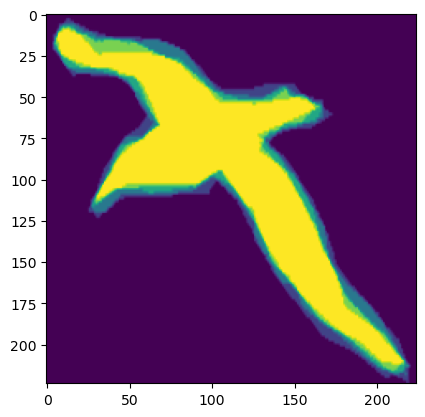

In [19]:
plt.imshow(mask_img.transpose(1, 2, 0))

In [9]:
mask0[100][150]

1.0